# ADM HW-4

1. Mert YILDIZ
2. Ousainou Panneh

## Q-1 Hashing

In [1]:
import pandas as pd

In [3]:
# Calculate the length of the hash file.

from tqdm import tqdm
count = 0
for line in tqdm(open(r'hash.txt', encoding= 'utf-8')):
    count = count + 1
print(count)

139000000it [02:53, 801343.15it/s] 

139000000


In [5]:
df_new = pd.read_csv('hash.txt', names= ['Hexadecimals'], encoding= 'utf-8', nrows = 10000000)

In [6]:
df_new.head()

,Hexadecimals
0,844082e02a27ddee8d99ea1af94a2969
1,ff96d6665b5c59d3a70bb8f2ba4f10be
2,b64a85884e2b159829331c19e05dbac9
3,1c8836719e84867c26ba2cfeb372c53d
4,b66f73ffd9008d9c99159e164261df51


### Define the hash function. We have split each hexadecimals to two part from the middle and switch the substrings.

In [7]:
# Define the hash function from scratch.

def my_hash(value):
    
    bucket = value[:int(len(value)/2)]     # Define the bucket as the first half of the hexadecimal.
    remaining = value[int(len(value)/2):]  # Take the other half of the hexadecimal and set it as remaining.
    y = remaining + bucket                 # Switch the bucket and remaining.

    return int(y, 16)

### We have estimated the cardinality by hyperloglog. In here we counts the zeros from the end of each bucket.

In [8]:
def trailing_zeroes(num):
    
    #Counts the number of trailing 0 bits in num.
    
    if num == 0:
        return 32 # Assumes 32 bit integer inputs!
    p = 0
    while (num >> p) & 1 == 0:
        p += 1
    return p

def estimate_cardinality(values, k):
    
    num_buckets = 2 ** k
    max_zeroes = [0] * num_buckets
    
    for value in tqdm(values):
        
        h = my_hash(value) # Use the hash function we have defined from scratch above.
        bucket = h & (num_buckets - 1)
        bucket_hash = h >> k
        max_zeroes[bucket] = max(max_zeroes[bucket], trailing_zeroes(bucket_hash))
        cardinality = 2 ** (float(sum(max_zeroes)) / num_buckets) * num_buckets * 0.79402, max(max_zeroes)
        
    return cardinality

### Since the data is big we have read it by splitting to 139 bucket and estimate the cardinality.

In [10]:
cardinality_list = []

# Read 1000000 rows each time as chunk and go through all data. ,
# Estimate the cardinality for each chunk and append to the cardinality list.

for df_new in pd.read_csv('hash.txt', names= ['Hexadecimals'], encoding= 'utf-8', chunksize=1000000):

    Values = df_new['Hexadecimals']
    x,y = estimate_cardinality(Values, 16)
    cardinality_list.append(x)
    

100%|████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:07<00:00, 134092.18it/s]


100%|████████████████████████████████████████████████████████████████████| 1000000/1000000 [00:07<00:00, 135160.83it/s]

The cardinality: 139041822.46047446
The error:  0.0003008810106076354


### We have sum the estimated cardinality for all bucket and calculate the error.

In [11]:
print('The cardinality:', sum(cardinality_list))
print ('The error: ' , (abs(sum(cardinality_list)-count))/count)

The cardinality: 139041822.46047446
The error:  0.0003008810106076354


## Q-2

In [19]:
import sqlite3, pandas as pd, numpy as np, nltk, string, matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
import string
from nltk.corpus import stopwords
from gensim.models import Word2Vec, KeyedVectors
import pickle
import warnings
warnings.filterwarnings("ignore")
import math
from sklearn.datasets import *
import sklearn.datasets
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from wordcloud import WordCloud
from tqdm import tqdm
import re

In [220]:
df = pd.read_csv('Reviews.csv')

df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


### Preprocessing the data

In [223]:
# Deduplicating the review.

df_sorted=df.sort_values('Time', axis=0, ascending=False, inplace=False, kind='quicksort', na_position='last')
df_unique=df_sorted.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

#Removing the entries where HelpfulnessNumerator > HelpfulnessDenominator.

df_final=df_unique[df_unique.HelpfulnessNumerator <= df_unique.HelpfulnessDenominator]

# https://stackoverflow.com/a/47091490/4084039
# https://en.wikipedia.org/wiki/Wikipedia:List_of_English_contractions

def decontracted(sentence):
    # specific
    sentence = re.sub(r"won't", "will not", sentence)
    sentence = re.sub(r"can\'t", "can not", sentence)

    # general
    sentence = re.sub(r"n\'t", " not", sentence)
    sentence = re.sub(r"\'re", " are", sentence)
    sentence = re.sub(r"\'s", " is", sentence)
    sentence = re.sub(r"\'d", " would", sentence)
    sentence = re.sub(r"\'ll", " will", sentence)
    sentence = re.sub(r"\'t", " not", sentence)
    sentence = re.sub(r"\'ve", " have", sentence)
    sentence = re.sub(r"\'m", " am", sentence)
    return sentence

#Remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
def removeNumbers(sentence):
    sentence = re.sub("\S*\d\S*", " ", sentence).strip()
    return sentence

#Function to clean html tags from a sentence
def removeHtml(sentence): 
    pattern = re.compile('<.*?>')
    sentence = re.sub(pattern,' ',sentence)
    return sentence

#Remove URL from sentences.
def removeURL(sentence):
    text = re.sub(r"http\S+", " ", sentence)
    sentence = re.sub(r"www.\S+", " ", text)
    return sentence
    
#Function to keep only words containing letters A-Z and a-z. This will remove all punctuations, special characters etc. https://stackoverflow.com/a/5843547/4084039
def removePunctuations(sentence):
    sentence  = re.sub('[^a-zA-Z]',' ',sentence)
    return sentence

#https://stackoverflow.com/questions/37012948/regex-to-match-an-entire-word-that-contains-repeated-character
#Remove words like 'zzzzzzzzzzzzzzzzzzzzzzz', 'testtting', 'grrrrrrreeeettttt' etc. Preserves words like 'looks', 'goods', 'soon' etc. We will remove all such words which has three consecutive repeating characters.
def removePatterns(sentence): 
    sentence  = re.sub("\\s*\\b(?=\\w*(\\w)\\1{2,})\\w*\\b",' ',sentence)
    return sentence

from nltk.stem import WordNetLemmatizer 
lemmatizer = WordNetLemmatizer() 

#Removing the word 'not' from stopwords
default_stopwords = set(stopwords.words('english'))
remove_not = set(['no', 'nor', 'not'])
custom_stopwords = default_stopwords - remove_not

In [224]:
#Processing review Texts
preprocessed_reviews = [] #Store all the processed reviews
count=0     
string=' '    
stemed_word=' '

for review in tqdm(df_final['Text'].values):
    filtered_sentence=[]
    review = decontracted(review)
    review = removeNumbers(review)
    review = removeHtml(review)
    review = removeURL(review)
    review = removePunctuations(review)
    review = removePatterns(review)
    
    for cleaned_words in review.split():   
        if((cleaned_words not in custom_stopwords) and (2<len(cleaned_words)<16)):
            lemmatized_word=(lemmatizer.lemmatize(cleaned_words.lower()))                                   
            filtered_sentence.append(lemmatized_word)
        else:
            continue
    review = " ".join(filtered_sentence)     
    preprocessed_reviews.append(review.strip())
    count+=1
    
df_final['CleanedText']=preprocessed_reviews 
    
print("The length of the data corpus is : {}".format(len(preprocessed_reviews)))

100%|████████████████████████████████████████████████████████████████████████| 393931/393931 [01:58<00:00, 3322.90it/s]

The length of the data corpus is : 393931


In [228]:
df_final['Text'].iloc[0]

"Rooibos Natural Red tea is something of a personal taste! It has an interesting flavor as all things that are good for you do! I prefer to add a little cinnamon to mine. It is known to be used for people who get GOUT and since I do , I have had no incidents since drinking this tea! If it works, use it! It is a good tea and caffeine free. Some prefer it with sugar!Give it a try too for it's calming effect!"

In [227]:
df_final['CleanedText'].iloc[0]

'rooibos natural red tea something personal taste interesting flavor thing good prefer add little cinnamon mine known used people get gout since incident since drinking tea work use good tea caffeine free prefer sugar give try calming effect'

In [229]:
## Similarly you can do preprocessing for summary also.
import warnings
warnings.filterwarnings("ignore")

preprocessed_summary = [] 
 
count=0     
string=' '    
stemed_word=' '

for summary in tqdm(df_final['Summary'].values):
    filtered_sentence=[]
    summary = decontracted(summary)
    summary = removeNumbers(summary)
    summary = removeHtml(summary)
    summary = removeURL(summary)
    summary = removePunctuations(summary)
    summary = removePatterns(summary)
    
    for cleaned_words in summary.split():
        if(2<len(cleaned_words)<16):
            lemmatized_word=(lemmatizer.lemmatize(cleaned_words.lower()))
            filtered_sentence.append(stemed_word)
    summary = " ".join(filtered_sentence)    
    preprocessed_summary.append(summary.strip()) 
    count+=1
     
df_final['CleanedSummary']=preprocessed_summary

#Store the cleaned data once and read it later no need to clean the data every time.
df_final.to_csv('Reviews_updated.csv', index = False, header=True)

100%|███████████████████████████████████████████████████████████████████████| 393931/393931 [00:13<00:00, 29902.65it/s]


In [22]:
df = pd.read_csv('Reviews_updated.csv')

# Combine the text for each product.
df = df.groupby(['ProductId'], as_index = False).agg({'Text': ' '.join})

X_corpus = df['Text']

### Clustering

In [23]:
import numpy as np # linear algebra
from sklearn.cluster import KMeans 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.preprocessing import normalize
from sklearn.metrics import pairwise_distances
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
from scipy.stats import multivariate_normal as mvn
import nltk
import os
import random

#### Since we have thousands of words tfidf vectorizer is not works well so we have used SVD.

In [24]:
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import make_pipeline

tfidf_vectorizer = TfidfVectorizer(max_df=0.5, max_features=10000, min_df=2, stop_words='english', use_idf=True)
X = tfidf_vectorizer.fit_transform(X_corpus)

svd = TruncatedSVD(1000)
normalizer = Normalizer(copy=False)
lsa = make_pipeline(svd, normalizer)
Xnew = lsa.fit_transform(X)

#### We have used the elbow method to find the optimum number of clusters first.

In [252]:
from tqdm import tqdm
distortions = []
K = range(1,12)
for k in tqdm(K):
    kmeanModel = KMeans(n_clusters=k,init='k-means++')
    kmeanModel.fit(Xnew)
    distortions.append(kmeanModel.inertia_)

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [04:59<00:00, 27.26s/it]


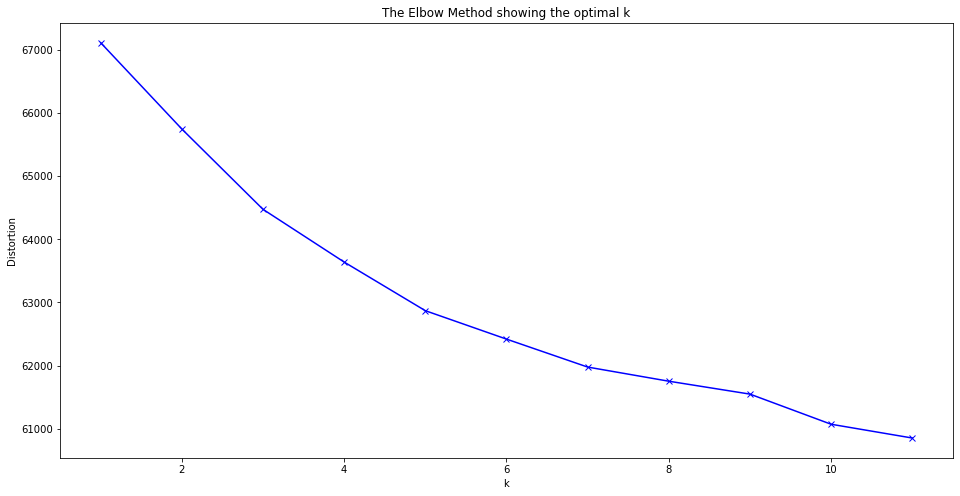

In [253]:
plt.figure(figsize=(16,8))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

#### According to the elbow method the number of cluster should be 7. And here you can see the kmeans clustering applied from scratch.

In [263]:
import random
init_centroids = random.sample(range(0, len(Xnew)), 7)
init_centroids

[36745, 59945, 7668, 59968, 65457, 8180, 29996]

In [266]:
centroids = []
for i in init_centroids:
    centroids.append(Xnew[i])
centroids

[array([ 1.34537943e-01, -1.72117047e-02, -1.41323575e-02, -3.63775052e-02,
        -7.88716062e-02, -9.62964279e-02,  1.04804345e-03,  1.77865637e-01,
         7.32171372e-02, -6.17710473e-02,  3.16029725e-02,  3.82570083e-02,
        -6.09855235e-02, -8.04557502e-02, -5.36826561e-02, -1.51459297e-02,
         7.53991219e-04, -2.22051692e-02,  6.65225227e-02, -3.67030312e-02,
         2.36552708e-02,  1.01204814e-02, -4.03608968e-02,  8.22684874e-03,
        -5.08075134e-02, -3.18117545e-02,  6.99913990e-03, -1.53345016e-02,
        -1.87929857e-02, -5.30303747e-02,  1.53664305e-01,  8.20851642e-02,
        -8.60351128e-02, -9.58769197e-03, -1.97558606e-01, -1.82581051e-01,
        -8.73769979e-02,  3.79285175e-02, -1.43687468e-02, -3.07215580e-02,
         2.49717528e-02, -1.47741728e-01, -6.13426060e-02, -4.40773705e-02,
        -2.36861245e-02,  3.70239927e-02,  3.01623206e-02,  7.27633368e-02,
         2.23175697e-02, -7.17249099e-02, -9.32669292e-02, -2.45087423e-03,
        -3.7

In [267]:
centroids = np.array(centroids)

In [268]:
centroids

array([[ 0.13453794, -0.0172117 , -0.01413236, ..., -0.01359586,
        -0.00226427, -0.00251742],
       [ 0.35647103, -0.11331838, -0.07132611, ...,  0.00735037,
        -0.00606854, -0.03197299],
       [ 0.44429684, -0.13425128, -0.09317595, ...,  0.00223561,
         0.00126008, -0.00051037],
       ...,
       [ 0.08817242, -0.02330184, -0.00277644, ...,  0.01989237,
        -0.01278473,  0.01024671],
       [ 0.32843217, -0.11117192, -0.08009033, ..., -0.00778595,
         0.0023979 , -0.02538531],
       [ 0.34516326, -0.07767572, -0.02843772, ...,  0.01958998,
         0.00745263,  0.01216634]])

In [269]:
def calc_distance(X1, X2):
    return(np.linalg.norm(X1-X2))

def findClosestCentroids(ic, X):
    assigned_centroid = []
    for i in tqdm(X):
        distance=[]
        for j in ic:
            distance.append(calc_distance(i, j))
        assigned_centroid.append(np.argmin(distance))
    return assigned_centroid

def calc_centroids(clusters, X):
    new_centroids = []
    new_df = pd.concat([pd.DataFrame(X), pd.DataFrame(clusters, columns=['cluster'])],
                      axis=1)
    for c in set(new_df['cluster']):
        current_cluster = new_df[new_df['cluster'] == c][new_df.columns[:-1]]
        cluster_mean = current_cluster.mean(axis=0)
        new_centroids.append(cluster_mean)
    return new_centroids

100%|█████████████████████████████████████████████████████████████████████████| 70992/70992 [00:03<00:00, 19952.56it/s]


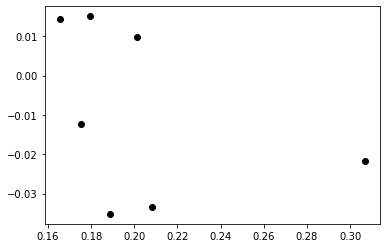

100%|██████████████████████████████████████████████████████████████████████████| 70992/70992 [00:58<00:00, 1211.94it/s]


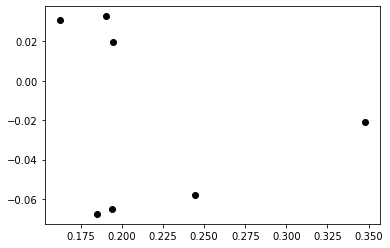

100%|██████████████████████████████████████████████████████████████████████████| 70992/70992 [01:05<00:00, 1089.03it/s]


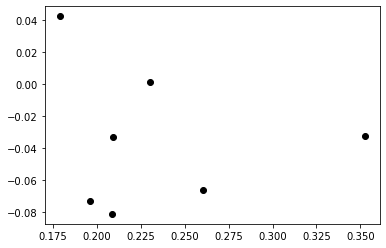

100%|██████████████████████████████████████████████████████████████████████████| 70992/70992 [01:10<00:00, 1003.45it/s]


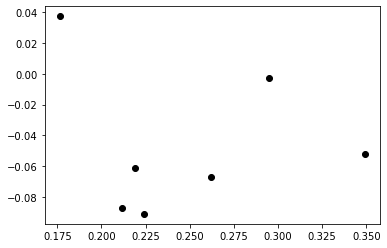

100%|██████████████████████████████████████████████████████████████████████████| 70992/70992 [01:10<00:00, 1012.08it/s]


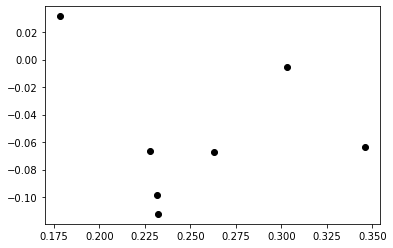

100%|███████████████████████████████████████████████████████████████████████████| 70992/70992 [01:12<00:00, 977.26it/s]


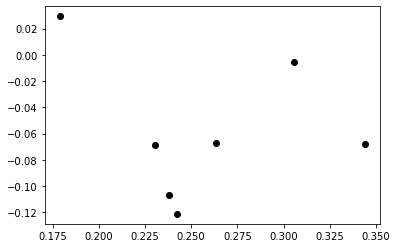

100%|██████████████████████████████████████████████████████████████████████████| 70992/70992 [01:08<00:00, 1032.86it/s]


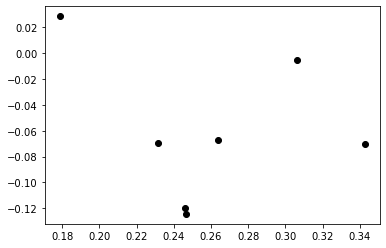

100%|██████████████████████████████████████████████████████████████████████████| 70992/70992 [01:07<00:00, 1053.70it/s]


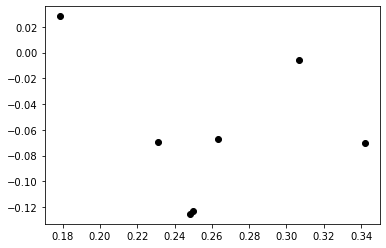

100%|██████████████████████████████████████████████████████████████████████████| 70992/70992 [01:08<00:00, 1038.45it/s]


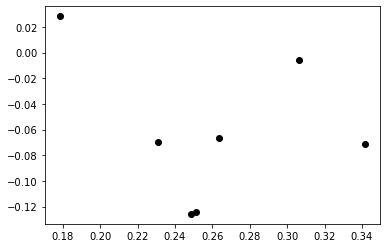

100%|██████████████████████████████████████████████████████████████████████████| 70992/70992 [01:07<00:00, 1058.75it/s]


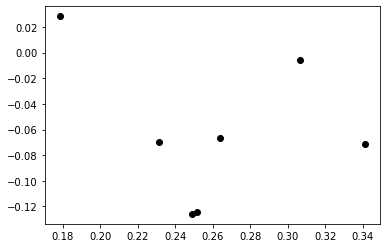

In [277]:
for i in range(10):
    
    get_centroids = findClosestCentroids(centroids, Xnew)
    centroids = calc_centroids(get_centroids, Xnew)
  
    #print(centroids)
    plt.figure()
    plt.scatter(np.array(centroids)[:, 0], np.array(centroids)[:, 1], color='black')
    #plt.scatter(X[:, 0], X[:, 1], alpha=0.1)
    plt.show()

#### And in here we are applying the k-means++ and comparing our centroids.  We can see that there is no big difference between our implementation from scratch and k-means++.

In [10]:
kmeans = KMeans(n_clusters=7, init='k-means++', random_state=0).fit(Xnew)

In [281]:
for i in range(7):
    a = centroids[i]-kmeans.cluster_centers_[i]
    print(np.sum(a))

0.06461294869785898
-0.634059826818119
-0.7119046400390828
0.7877686704400164
0.3546961324970347
-0.01920548025574248
-0.18074967712463128


#### Q-2 Analyze

In [31]:
df = pd.read_csv('Reviews_updated.csv')

X_corpus = df['CleanedText']

In [32]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_corpus.values.astype('U'))

In [33]:
kmeans = KMeans(n_clusters=7, init='k-means++', random_state=0).fit(X)

#### Identify the kind of products in the cluster (e.g., chips, tea, coffee) using a visualization called word cloud.

In [34]:
labels=kmeans.labels_
clusters_dict = {i: np.where(labels == i)[0] for i in range(7)}

  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

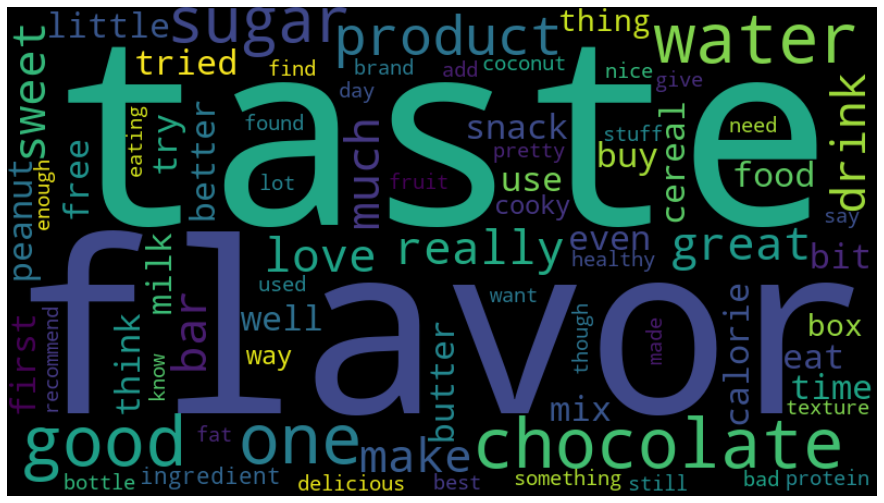

 14%|████████████                                                                        | 1/7 [01:14<07:26, 74.39s/it]

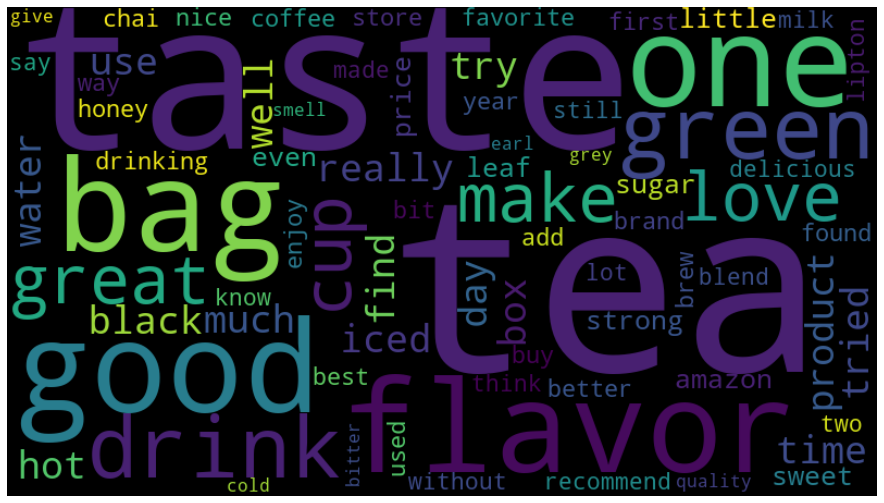

 29%|████████████████████████                                                            | 2/7 [01:18<04:26, 53.31s/it]

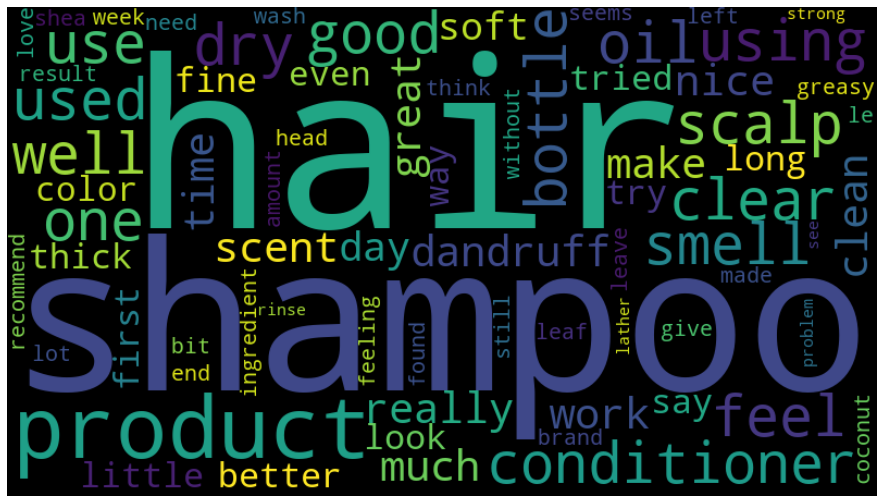

 43%|████████████████████████████████████                                                | 3/7 [01:20<02:31, 37.91s/it]

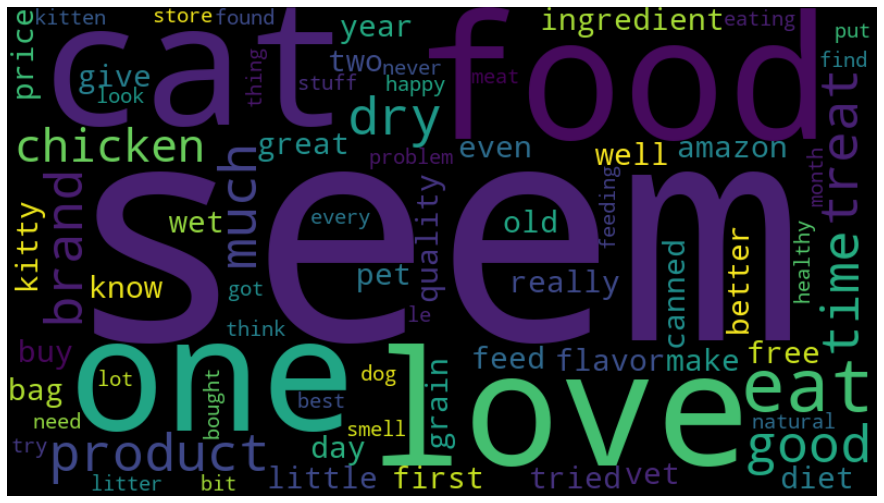

 57%|████████████████████████████████████████████████                                    | 4/7 [01:22<01:21, 27.03s/it]

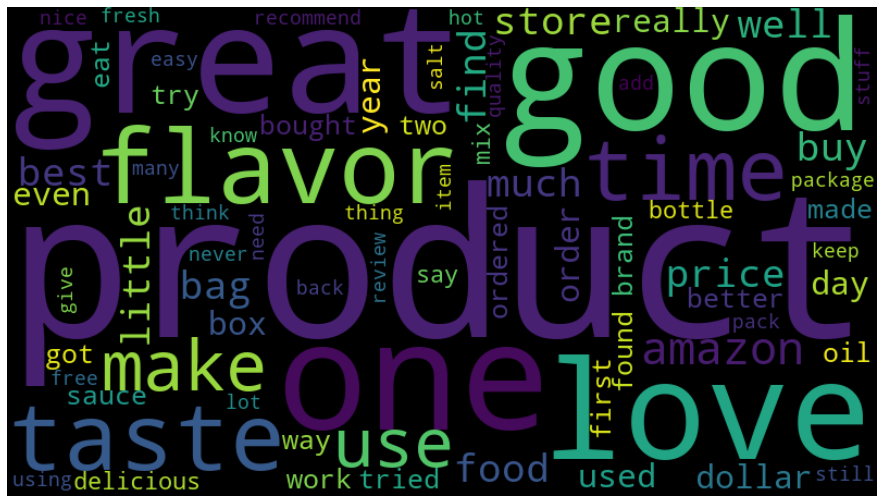

 71%|███████████████████████████████████████████████████████████▎                       | 5/7 [06:48<03:53, 116.97s/it]

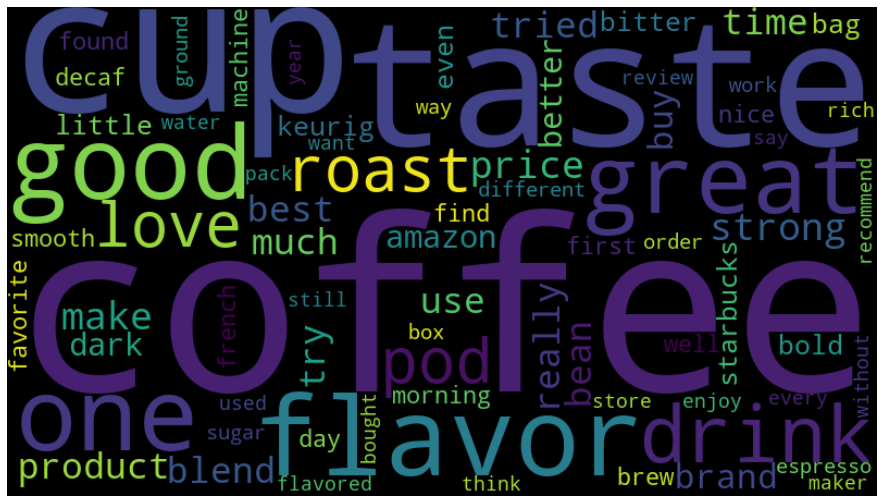

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [06:57<01:24, 84.52s/it]

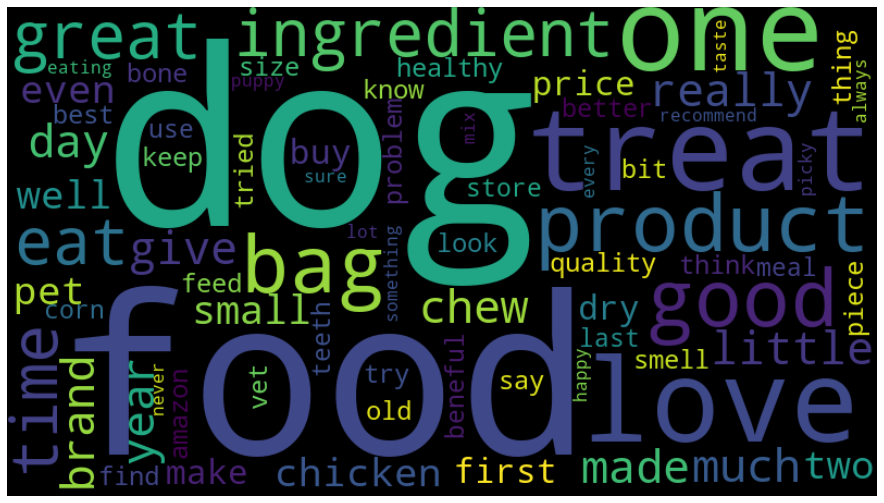

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [07:03<00:00, 60.46s/it]


In [35]:
from collections import Counter
for i in tqdm(range(len(clusters_dict))):
    
    df_upd = df.iloc[clusters_dict[i]]
    
    s = ''
    for i in df_upd['CleanedText']:
        s =  s +  ' ' + str(i) 
    
    t = ''
    for j in Counter(s.split()).most_common(100):
        t = t +' '+ j[0]
        
    wordcloud = WordCloud(width=800, height=450, margin=2, prefer_horizontal=0.9, scale=1, max_words=75, 
                              min_font_size=4, random_state=42, background_color='black', 
                              contour_color='black', repeat=False, ).generate(str(t))
    plt.figure(figsize=(16,9))
    # plt.title("Word Cloud for Cluster {}".format(cluster_number))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

#### Provide the number of product in each cluster.

In [36]:
for i in tqdm(range(len(clusters_dict))):
    print ('The number of product in cluster ' +str(i) + ' is ' + str(len(clusters_dict[i])))

100%|██████████████████████████████████████████████████████████████████████████████████| 7/7 [00:00<00:00, 7020.59it/s]

The number of product in cluster 0 is 22031
The number of product in cluster 1 is 5488
The number of product in cluster 2 is 1875
The number of product in cluster 3 is 2421
The number of product in cluster 4 is 53593
The number of product in cluster 5 is 8926
The number of product in cluster 6 is 5666


#### Compute the reviews' score distribution in each cluster. Once you get them, test if their mean differences are statistically significant!


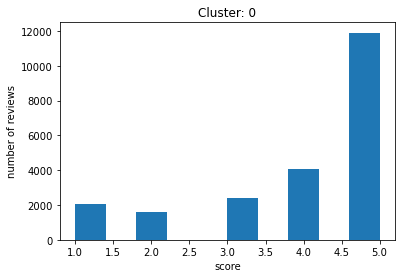

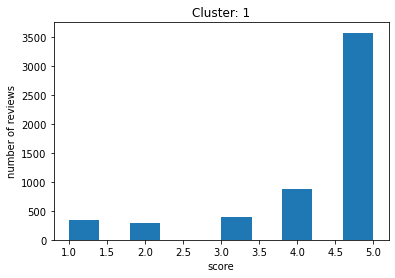

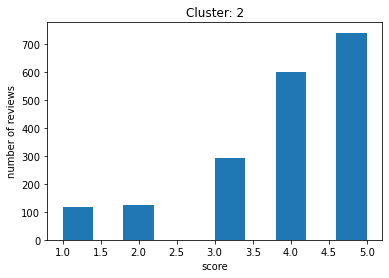

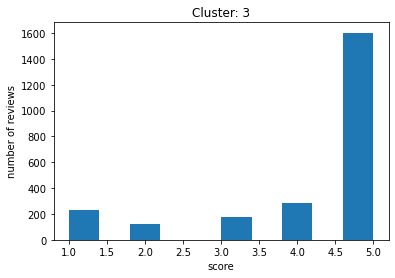

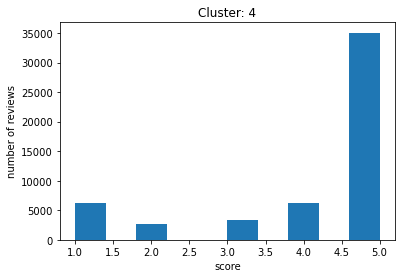

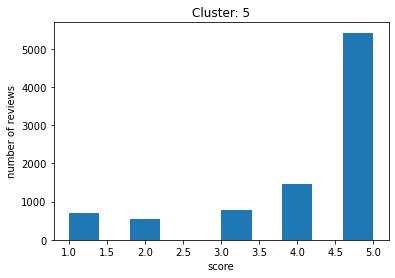

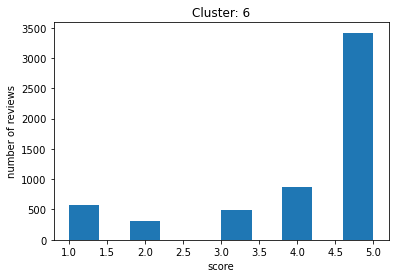

In [37]:
for j in range(len(clusters_dict.keys())):
    plt.hist(df.iloc[clusters_dict[j]]['Score'])
    plt.title("Cluster: " + str(j))
    plt.xlabel("score")
    plt.ylabel("number of reviews")
    plt.show()

#### Get the number of unique users writing reviews in each cluster.

In [38]:
for j in range(len(clusters_dict.keys())):
    print('The number of uniq users writing review for cluster' + str(j)+ ' is ' + str(df.iloc[clusters_dict[j]].UserId.nunique()))

The number of uniq users writing review for cluster0 is 17055
The number of uniq users writing review for cluster1 is 4800
The number of uniq users writing review for cluster2 is 1163
The number of uniq users writing review for cluster3 is 2042
The number of uniq users writing review for cluster4 is 44968
The number of uniq users writing review for cluster5 is 7945
The number of uniq users writing review for cluster6 is 4741


## Q-3

You are given an array with A with n integer numbers.
•	Let s = min{ A[1], ..., A[n] } and b = max { A[1], ..., A[n] }.
•	Let r = b - s
Prove that we can sort A in time O(n + r).


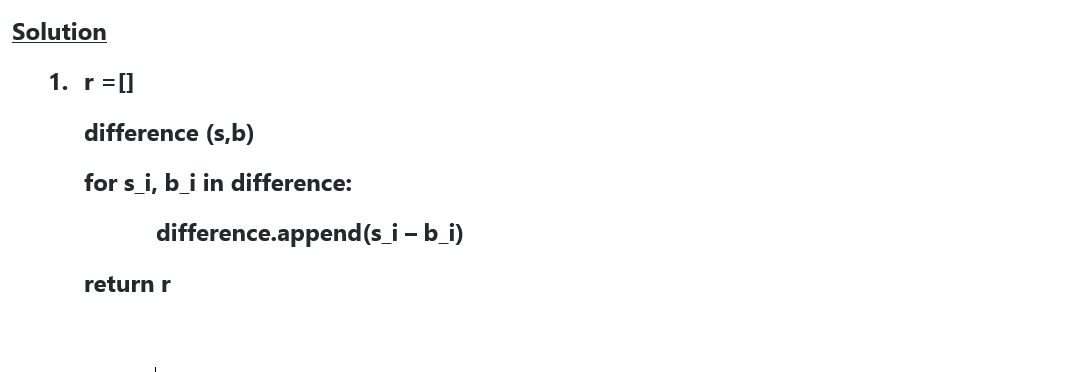


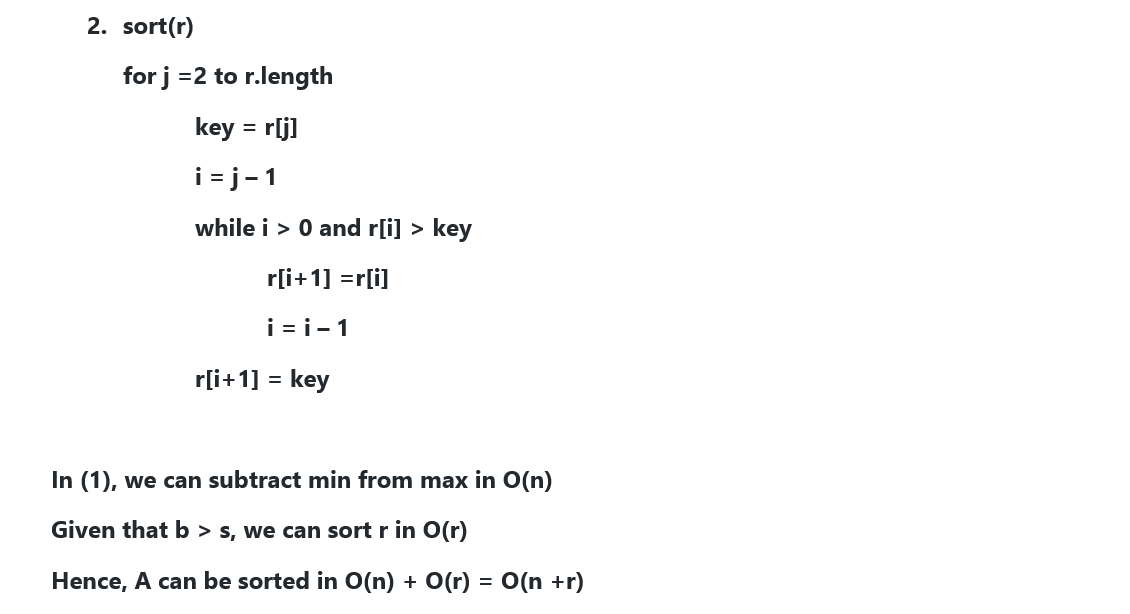